In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute



c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\Student_performance_data _.csv')


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2392 non-null   int64  
 1   Gender             2392 non-null   int64  
 2   Ethnicity          2392 non-null   int64  
 3   ParentalEducation  2392 non-null   int64  
 4   StudyTimeWeekly    2392 non-null   float64
 5   Absences           2392 non-null   int64  
 6   Tutoring           2392 non-null   int64  
 7   ParentalSupport    2392 non-null   int64  
 8   Extracurricular    2392 non-null   int64  
 9   Sports             2392 non-null   int64  
 10  Music              2392 non-null   int64  
 11  Volunteering       2392 non-null   int64  
 12  GPA                2392 non-null   float64
 13  GradeClass         2392 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 261.8 KB


Learning the structure of the Bayesian Network...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 2/1000000 [00:00<101:38:32,  2.73it/s]


Bayesian Network Structure:
[('GradeClass', 'Absences'), ('GradeClass', 'Tutoring')]


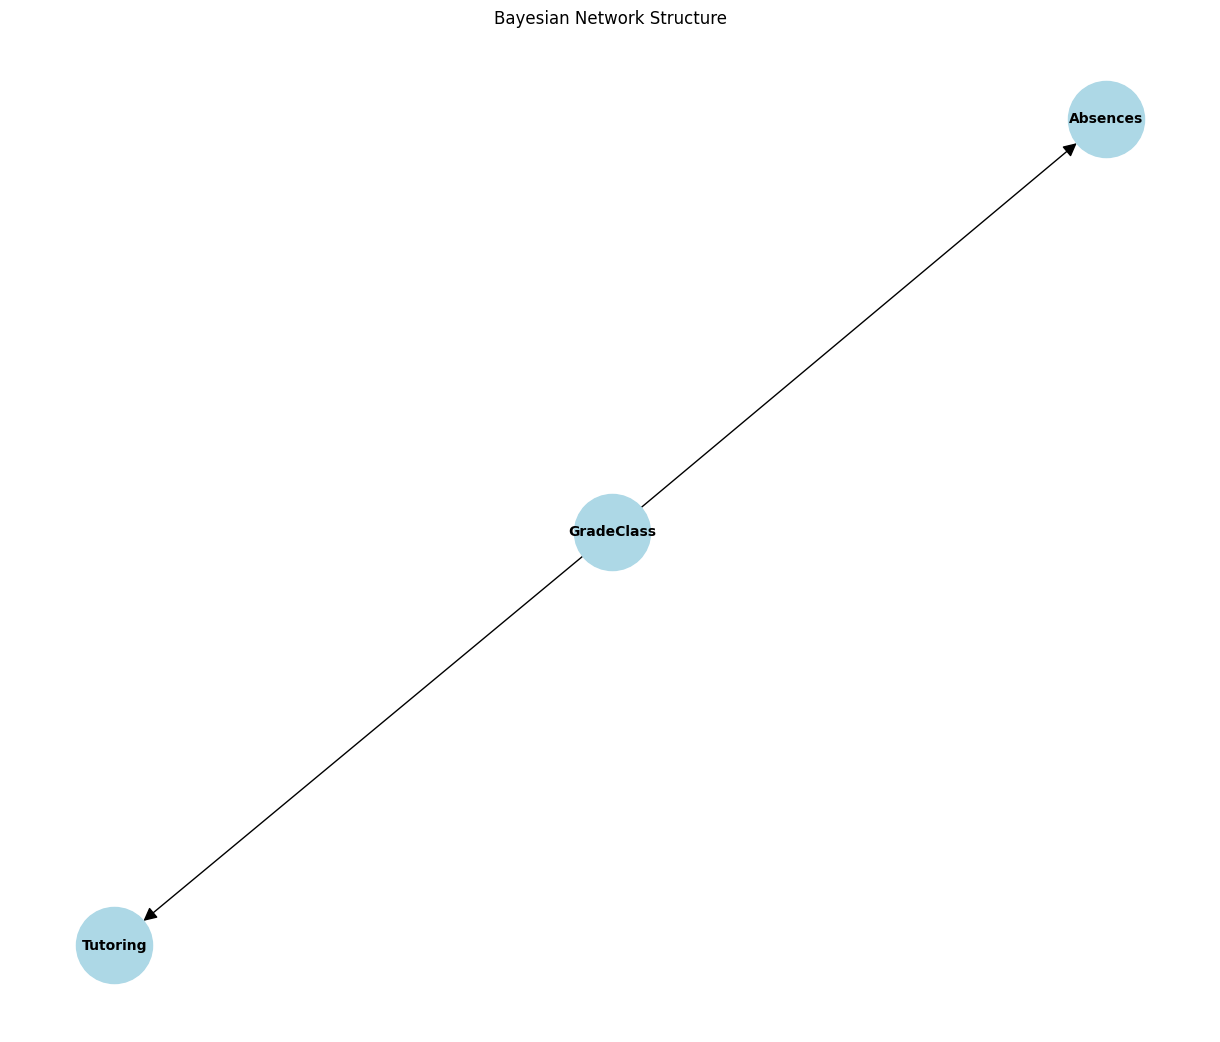

Fitting the Bayesian Network with data...


In [5]:


'''''
# Step 2: Identify missingness indicators
# Add missingness indicators for each column with missing values
missing_indicators = {}
for column in data.columns:
    if data[column].isnull().any():
        missing_indicators[f'R_{column}'] = data[column].isnull().astype(int)

# Add missingness indicators to the dataset
for key, value in missing_indicators.items():
    data[key] = value

'''''

# Drop rows with missing values temporarily for structure learning
data_complete = data.dropna()



# Step 3: Learn the structure of the Bayesian Network
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data_complete)
model = hc.estimate(scoring_method=BicScore(data_complete))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [6]:
inference = VariableElimination(bayesian_net)


# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["Tutoring", "Absences","GradeClass"])
print("\nJoint Probability")
print(query_result)



Joint Probability
+-------------+--------------+---------------+-------------------------------------+
| Tutoring    | Absences     | GradeClass    |   phi(Tutoring,Absences,GradeClass) |
+=============+==============+===============+=====================================+
| Tutoring(0) | Absences(0)  | GradeClass(0) |                              0.0056 |
+-------------+--------------+---------------+-------------------------------------+
| Tutoring(0) | Absences(0)  | GradeClass(1) |                              0.0067 |
+-------------+--------------+---------------+-------------------------------------+
| Tutoring(0) | Absences(0)  | GradeClass(2) |                              0.0029 |
+-------------+--------------+---------------+-------------------------------------+
| Tutoring(0) | Absences(0)  | GradeClass(3) |                              0.0006 |
+-------------+--------------+---------------+-------------------------------------+
| Tutoring(0) | Absences(0)  | GradeClass(4) |

In [7]:
result = inference.query(variables=["Tutoring"], evidence={ "GradeClass": True})
print("Conditional Probability P(Tutoring | GradeClass = True):")
print(result)

Conditional Probability P(Tutoring | GradeClass = True):
+-------------+-----------------+
| Tutoring    |   phi(Tutoring) |
+=============+=================+
| Tutoring(0) |          0.5948 |
+-------------+-----------------+
| Tutoring(1) |          0.4052 |
+-------------+-----------------+


In [8]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['GradeClass', 'Absences', 'Tutoring']
Edges in the Bayesian Network:
[('GradeClass', 'Absences'), ('GradeClass', 'Tutoring')]
